<h1> Imports

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
import os
import random

In [85]:
# !pip install torchtext==0.10.0 --user

In [86]:
# !pip install torch==1.11.0 torchtext==0.12.0 --user

In [87]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

<h1>Import Data

In [88]:
max_words = 25

In [89]:
data = pd.read_csv('../Data/news-article-categories-clean.csv')

<h1> Vocabulary

In [90]:
tokenizer = get_tokenizer("basic_english")

data['tok_body'] = data.body.apply(lambda x: tokenizer(x))

vocab = build_vocab_from_iterator(data['tok_body'], min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

len(vocab)

66936

<h1> Tokenization

In [91]:
data["cat"] = pd.Categorical(data.category)
data['cat_code'] = data.cat.cat.codes

In [92]:
data["body_tok"] = data["body"].apply(lambda x: vocab(tokenizer(x)))

In [93]:
data["body_max_len"] = data["body_tok"].apply(lambda x: x+([0]* (max_words-len(x))) if len(x)<max_words else x[:max_words])

In [94]:
#Dropping rows of the biggest category so the RNN doesn't overfit
data = data.drop(range(0, 500), axis = 0)
data.reset_index(drop=True, inplace=True)

In [95]:
data_sans_na = data.dropna()
data_sans_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   category      6371 non-null   object  
 1   title         6371 non-null   object  
 2   body          6371 non-null   object  
 3   tok_body      6371 non-null   object  
 4   cat           6371 non-null   category
 5   cat_code      6371 non-null   int8    
 6   body_tok      6371 non-null   object  
 7   body_max_len  6371 non-null   object  
dtypes: category(1), int8(1), object(6)
memory usage: 311.9+ KB


<h1>Target Classes

In [96]:
target_classes = ["ART & CULTURE","BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]
# target_classes = ["BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]

In [97]:
len(target_classes)

14

In [98]:
target_classes_int = [i for i in range(14)]

<h1>Train / Test Split

In [99]:
X = data_sans_na.drop(["category", "cat_code", "cat"], axis =1)
y = data_sans_na["cat_code"]

In [100]:
X.head()

,title,body,tok_body,body_tok,body_max_len
0,"John Williams Has Never Seen 'Star Wars,' Does...",musical composition simply destined live forev...,"[musical, composition, simply, destined, live,...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6..."
1,"An Alert, Well-Hydrated Artist in No Acute Dis...",serial two artist incurable neurological disea...,"[serial, two, artist, incurable, neurological,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,..."
2,Stage Door: Ute Lemper's Songs From The Broken...,ute lemper acclaimed german chanteuse bares co...,"[ute, lemper, acclaimed, german, chanteuse, ba...","[41585, 24026, 4984, 2130, 34756, 43671, 10456...","[41585, 24026, 4984, 2130, 34756, 43671, 10456..."
3,Donna Quesada: Art Review,dear friend larry payne mentioned purchased th...,"[dear, friend, larry, payne, mentioned, purcha...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,..."
4,Top 5 Sizzling Hot Winter Music Festivals in F...,andrew cyrille photo petra cvelbar thelonious ...,"[andrew, cyrille, photo, petra, cvelbar, thelo...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1..."


In [101]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: cat_code, dtype: int8

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [103]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

<h1> Vectorize Batch

In [104]:
def vectorize_batch(batch):
    Y = tuple(map(lambda x: x["label"], batch))
    X = tuple(map(lambda x: x["text"], batch))
    X_t = torch.tensor(X,dtype=torch.long)
    Y_t = torch.tensor(Y, dtype=torch.long)
    return X_t, Y_t 
   

<h1> Load Data

In [105]:
# Définir une classe pour transformer un Dataframe en Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['body_max_len']
        label = row['cat_code']
        return {'label': label, 'text': text}

# Créer une instance de la classe Dataset personnalisée
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [106]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn= vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [107]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


<h1> RNN

In [108]:
#Paramètres du modèle
EMBED_LEN = 500
HIDDEN_SIZE1 = 300
HIDDEN_SIZE2 = 300
HIDDEN_SIZE3 = 300
OUTPUT_SIZE = len(target_classes)
N_LAYERS = 5

In [109]:
#Classe pour le modèle RNN simple
class RNNClassifier1(nn.Module):
    def __init__(self):
        super(RNNClassifier1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE1, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        return self.linear(output[:,-1])

In [110]:
#Classe pour le modèle a multiple RNN 
class RNNClassifier2(nn.Module):
    def __init__(self):
        super(RNNClassifier2, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn1 = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.rnn2 = nn.RNN(input_size=HIDDEN_SIZE1, hidden_size=HIDDEN_SIZE2, num_layers=N_LAYERS, batch_first=True)
        self.rnn3 = nn.RNN(input_size=HIDDEN_SIZE2, hidden_size=HIDDEN_SIZE3, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE3, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn1(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        output, hidden = self.rnn2(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE2))
        output, hidden = self.rnn3(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE3))
        return self.linear(output[:,-1])

In [111]:
rnn_classifier1 = RNNClassifier1()

rnn_classifier1

RNNClassifier1(
  (embedding_layer): Embedding(66936, 500)
  (rnn): RNN(500, 200, num_layers=5, batch_first=True)
  (linear): Linear(in_features=200, out_features=14, bias=True)
)

In [112]:
rnn_classifier2 = RNNClassifier2()

rnn_classifier2

RNNClassifier2(
  (embedding_layer): Embedding(66936, 500)
  (rnn1): RNN(500, 200, num_layers=5, batch_first=True)
  (rnn2): RNN(200, 200, num_layers=5, batch_first=True)
  (rnn3): RNN(200, 200, num_layers=5, batch_first=True)
  (linear): Linear(in_features=200, out_features=14, bias=True)
)

In [113]:
for layer in rnn_classifier1.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(66936, 500)
Parameters : 
torch.Size([66936, 500])

Layer : RNN(500, 200, num_layers=5, batch_first=True)
Parameters : 
torch.Size([200, 500])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])

Layer : Linear(in_features=200, out_features=14, bias=True)
Parameters : 
torch.Size([14, 200])
torch.Size([14])



In [114]:
out = rnn_classifier1(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 14])

In [115]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def calc_val_loss_and_accuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        calc_val_loss_and_accuracy(model, loss_fn, val_loader)

<h1> Entrainement Single RNN

In [116]:
from torch.optim import Adam

epochs = 30
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier1()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [117]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train Loss : 2.628
Valid Loss : 2.609
Valid Acc  : 0.113


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train Loss : 2.485
Valid Loss : 2.510
Valid Acc  : 0.157


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train Loss : 2.224
Valid Loss : 2.421
Valid Acc  : 0.176


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Train Loss : 1.906
Valid Loss : 2.414
Valid Acc  : 0.186


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train Loss : 1.589
Valid Loss : 2.446
Valid Acc  : 0.203


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Train Loss : 1.270
Valid Loss : 2.497
Valid Acc  : 0.228


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Train Loss : 0.968
Valid Loss : 2.556
Valid Acc  : 0.246


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Train Loss : 0.683
Valid Loss : 2.731
Valid Acc  : 0.246


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Train Loss : 0.453
Valid Loss : 2.878
Valid Acc  : 0.254


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.281
Valid Loss : 3.004
Valid Acc  : 0.243


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.164
Valid Loss : 3.130
Valid Acc  : 0.259


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Train Loss : 0.095
Valid Loss : 3.333
Valid Acc  : 0.237


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.058
Valid Loss : 3.374
Valid Acc  : 0.262


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Train Loss : 0.038
Valid Loss : 3.454
Valid Acc  : 0.256


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.027
Valid Loss : 3.547
Valid Acc  : 0.262


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Train Loss : 0.021
Valid Loss : 3.589
Valid Acc  : 0.256


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Train Loss : 0.022
Valid Loss : 3.605
Valid Acc  : 0.266


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Train Loss : 0.019
Valid Loss : 3.657
Valid Acc  : 0.264


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Train Loss : 0.014
Valid Loss : 3.706
Valid Acc  : 0.256


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Train Loss : 0.012
Valid Loss : 3.757
Valid Acc  : 0.255


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Train Loss : 0.011
Valid Loss : 3.768
Valid Acc  : 0.267


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Train Loss : 0.009
Valid Loss : 3.775
Valid Acc  : 0.261


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.008
Valid Loss : 3.795
Valid Acc  : 0.264


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Train Loss : 0.008
Valid Loss : 3.842
Valid Acc  : 0.266


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train Loss : 0.006
Valid Loss : 3.842
Valid Acc  : 0.266


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Train Loss : 0.006
Valid Loss : 3.861
Valid Acc  : 0.271


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Train Loss : 0.006
Valid Loss : 3.865
Valid Acc  : 0.265


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Train Loss : 0.006
Valid Loss : 3.879
Valid Acc  : 0.264


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Train Loss : 0.006
Valid Loss : 3.899
Valid Acc  : 0.266


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Train Loss : 0.005
Valid Loss : 3.901
Valid Acc  : 0.275


In [118]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.2690196078431373

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.16      0.13      0.14       105
     BUSINESS       0.16      0.20      0.18        90
       COMEDY       0.33      0.47      0.39        62
        CRIME       0.19      0.17      0.18        52
    EDUCATION       0.39      0.42      0.41       106
ENTERTAINMENT       0.23      0.25      0.24        96
  ENVIRONMENT       0.28      0.27      0.27        96
        MEDIA       0.18      0.16      0.17        67
     POLITICS       0.30      0.29      0.30       111
     RELIGION       0.29      0.24      0.27        94
      SCIENCE       0.14      0.11      0.13        87
       SPORTS       0.56      0.53      0.55       117
         TECH       0.17      0.23      0.20        88
        WOMEN       0.24      0.19      0.22       104

     accuracy                           0.27      1275
    macro avg       0.26      0.26      0.26      1275
 w

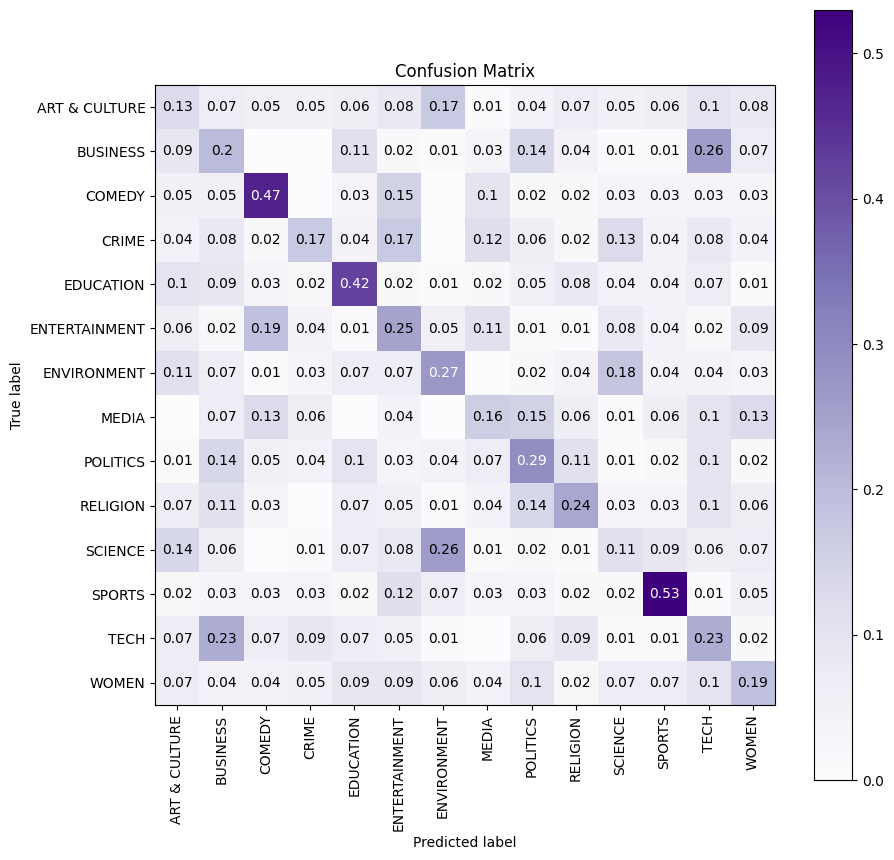

In [120]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);

<h1> Entrainement Multi RNN

In [121]:
epochs = 30
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier2()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [122]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Train Loss : 2.635
Valid Loss : 2.652
Valid Acc  : 0.076


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Train Loss : 2.622
Valid Loss : 2.626
Valid Acc  : 0.089


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Train Loss : 2.563
Valid Loss : 2.599
Valid Acc  : 0.107


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Train Loss : 2.473
Valid Loss : 2.539
Valid Acc  : 0.108


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Train Loss : 2.391
Valid Loss : 2.529
Valid Acc  : 0.118


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss : 2.313
Valid Loss : 2.524
Valid Acc  : 0.123


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Train Loss : 2.202
Valid Loss : 2.530
Valid Acc  : 0.121


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Train Loss : 2.106
Valid Loss : 2.586
Valid Acc  : 0.125


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Train Loss : 1.994
Valid Loss : 2.694
Valid Acc  : 0.131


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Train Loss : 1.880
Valid Loss : 2.735
Valid Acc  : 0.134


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Train Loss : 1.762
Valid Loss : 2.857
Valid Acc  : 0.125


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Train Loss : 1.621
Valid Loss : 2.936
Valid Acc  : 0.122


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Train Loss : 1.460
Valid Loss : 3.111
Valid Acc  : 0.136


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Train Loss : 1.316
Valid Loss : 3.242
Valid Acc  : 0.152


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Train Loss : 1.163
Valid Loss : 3.411
Valid Acc  : 0.135


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Train Loss : 1.061
Valid Loss : 3.575
Valid Acc  : 0.133


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Train Loss : 0.915
Valid Loss : 3.729
Valid Acc  : 0.140


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Train Loss : 0.780
Valid Loss : 3.983
Valid Acc  : 0.138


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Train Loss : 0.651
Valid Loss : 4.082
Valid Acc  : 0.125


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Train Loss : 0.550
Valid Loss : 4.291
Valid Acc  : 0.140


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Train Loss : 0.455
Valid Loss : 4.455
Valid Acc  : 0.125


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Train Loss : 0.389
Valid Loss : 4.626
Valid Acc  : 0.131


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Train Loss : 0.363
Valid Loss : 4.756
Valid Acc  : 0.142


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Train Loss : 0.331
Valid Loss : 4.941
Valid Acc  : 0.148


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Train Loss : 0.277
Valid Loss : 4.927
Valid Acc  : 0.142


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Train Loss : 0.249
Valid Loss : 5.027
Valid Acc  : 0.136


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Train Loss : 0.212
Valid Loss : 5.175
Valid Acc  : 0.145


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Train Loss : 0.176
Valid Loss : 5.227
Valid Acc  : 0.140


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Train Loss : 0.139
Valid Loss : 5.239
Valid Acc  : 0.133


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Train Loss : 0.122
Valid Loss : 5.381
Valid Acc  : 0.143


In [123]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.2690196078431373

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.16      0.13      0.14       105
     BUSINESS       0.16      0.20      0.18        90
       COMEDY       0.33      0.47      0.39        62
        CRIME       0.19      0.17      0.18        52
    EDUCATION       0.39      0.42      0.41       106
ENTERTAINMENT       0.23      0.25      0.24        96
  ENVIRONMENT       0.28      0.27      0.27        96
        MEDIA       0.18      0.16      0.17        67
     POLITICS       0.30      0.29      0.30       111
     RELIGION       0.29      0.24      0.27        94
      SCIENCE       0.14      0.11      0.13        87
       SPORTS       0.56      0.53      0.55       117
         TECH       0.17      0.23      0.20        88
        WOMEN       0.24      0.19      0.22       104

     accuracy                           0.27      1275
    macro avg       0.26      0.26      0.26      1275
 w

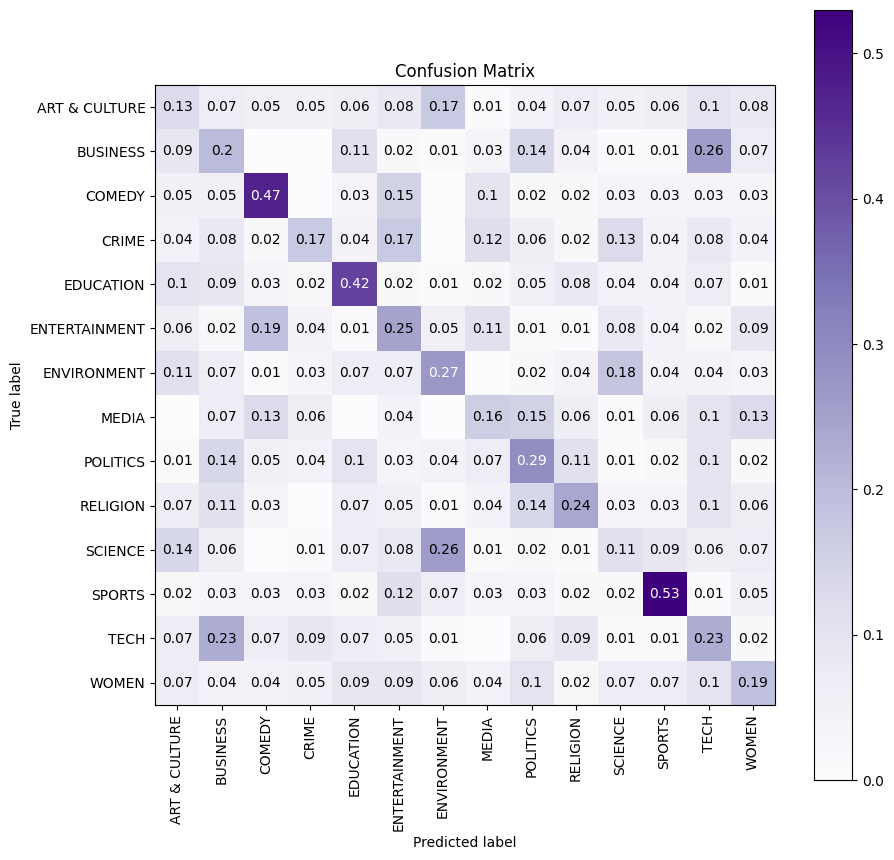

In [124]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);